<a href="https://colab.research.google.com/github/NinelK/SA_DS_tutorial/blob/main/LFADS_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [272]:
import datetime
import h5py
import jax.numpy as np
from jax import random
from jax.experimental import optimizers
from jax.config import config
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import scipy.signal
import scipy.stats
import os
import sys
import time
from importlib import reload

In [271]:
# %%capture
# ! pip install "dandi>=0.13.0"
# ! dandi download DANDI:000140/0.220113.0408 # Small
# ! dandi download DANDI:000138/0.220113.0407 # Large
# ! dandi download https://dandiarchive.org/dandiset/000129/draft
# ! dandi download https://dandiarchive.org/dandiset/000070/draft
# ! pip install git+https://github.com/neurallatents/nlb_tools.git
! git clone https://github.com/google-research/computation-thru-dynamics.git # needs Runtime restart?

2022-07-29 20:40:49,743 [    INFO] NumExpr defaulting to 2 threads.
PATH                                                              SIZE      DONE    DONE% CHECKSUM STATUS    MESSAGE    
dandiset.yaml                                                                                      skipped   no change  
sub-Jenkins/sub-Jenkins_ses-large_desc-test_ecephys.nwb                                                                 
sub-Jenkins/sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb                                                       
Summary:                                                          0 Bytes   0 Bytes                1 skipped 1 no change
                                                                  +149.4 MB 0.00%                                       


ERROR: 2 asynchronous workers failed

Producing value for row ('sub-Jenkins/sub-Jenkins_ses-large_desc-test_ecephys.nwb',) failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-

In [ ]:
# ! rm -r /content/jax-lfads

In [273]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '/content' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
sys.path.append(os.path.join(HOME_DIR,'jax-lfads'))
import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

import matplotlib.pyplot as plt
import pandas as pd
from nlb_tools.nwb_interface import NWBDataset

In [274]:
onp_rng = onp.random.RandomState(seed=0) # For CPU-based numpy randomness

In [275]:
# Make directories
lfads_dir = '/content/lfads/'       # where to save lfads data and parameters to
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(lfads_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

# Load data

# for simplicity, we are using NLB tools 
dataset = NWBDataset("/content/000138/sub-Jenkins", "*train", 
                     split_heldout=False)
# dataset = NWBDataset("/content/000129/sub-Indy", "*train", 
#                      split_heldout=False)

bin = 10 # [ms]
dataset.resample(bin)

# to view the dataset, uncomment the next line
# dataset.data

In [283]:
dataset.trial_info

,trial_id,start_time,end_time,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,move_onset_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target,split
0,0,0 days 00:00:00,0 days 00:00:03.341000,4,2,34,True,0 days 00:00:00.775000,0 days 00:00:01.773000,0 days 00:00:02.095000,322,998,3,"[[123, 69], [12, 84], [-126, 15]]",6,"[[63, 48, 10, 69], [36, 51, 51, 8], [91, -78, ...",2,train
1,1,0 days 00:00:03.400000,0 days 00:00:06.776000,2,1,32,True,0 days 00:00:04.300000,0 days 00:00:05.198000,0 days 00:00:05.606000,408,898,1,"[[12, 84]]",6,"[[63, 48, 10, 69], [36, 51, 51, 8], [91, -78, ...",0,train
2,2,0 days 00:00:06.800000,0 days 00:00:09.661000,7,1,37,True,0 days 00:00:07.582000,0 days 00:00:08.114000,0 days 00:00:08.452000,338,532,1,"[[103, 83]]",9,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",0,train
3,3,0 days 00:00:09.700000,0 days 00:00:12.476000,10,0,79,True,0 days 00:00:10.600000,0 days 00:00:11.015000,0 days 00:00:11.332000,317,415,1,"[[123, -81]]",0,[],0,train
4,4,0 days 00:00:12.500000,0 days 00:00:15.106000,11,0,80,True,0 days 00:00:13.364000,0 days 00:00:13.695000,0 days 00:00:13.992000,297,331,1,"[[123, 71]]",0,[],0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0 days 00:24:29.600000,0 days 00:24:32.636000,8,1,38,True,0 days 00:24:30.405000,0 days 00:24:31.153000,0 days 00:24:31.501000,348,748,1,"[[-105, 76]]",9,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",0,train
496,496,0 days 00:24:32.700000,0 days 00:24:35.746000,11,2,80,True,0 days 00:24:33.467000,0 days 00:24:34.116000,0 days 00:24:34.595000,479,649,3,"[[123, -81], [-130, -13], [123, 71]]",8,"[[-65, -15, 14, 51], [-79, -55, 55, 6], [-103,...",2,train
497,497,0 days 00:24:35.800000,0 days 00:24:38.801000,7,2,37,True,0 days 00:24:36.545000,0 days 00:24:37.410000,0 days 00:24:37.701000,291,865,3,"[[124, -79], [103, 83], [-105, 76]]",9,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",1,val
498,498,0 days 00:24:38.900000,0 days 00:24:41.956000,7,1,37,True,0 days 00:24:39.613000,0 days 00:24:40.479000,0 days 00:24:40.777000,298,866,1,"[[103, 83]]",9,"[[74, -102, 11, 53], [86, -44, 14, 11], [103, ...",0,train


In [278]:
input_key = 'spikes'
output_key = 'hand_vel'

# Extract neural data and lagged hand velocity
trial_length = 500//bin
trial_data = dataset.make_trial_data(align_field='move_onset_time', 
                                     align_range=(0, 0+bin*trial_length))

print(trial_data['trial_id'].to_numpy().reshape((-1,trial_length)))
inputs = trial_data[input_key].to_numpy() 
outputs = trial_data[output_key].to_numpy()

input_size = inputs.shape[-1]
output_size = outputs.shape[-1]

print(input_size,output_size)

inputs = inputs.reshape((-1,trial_length,input_size)) # [trials x time x inputs]
outputs = outputs.reshape((-1,trial_length,output_size)) # [trials x time x outputs]
 
data_bxtxn = inputs
data_bxtxn.shape

[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [497 497 497 ... 497 497 497]
 [498 498 498 ... 498 498 498]
 [499 499 499 ... 499 499 499]]
162 2


(500, 50, 162)

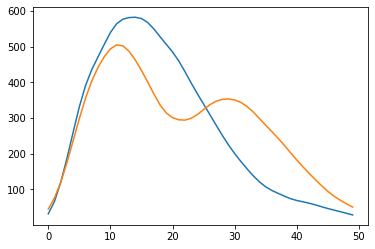

In [279]:
plt.plot(outputs.std(0))

In [282]:
data_dt = 10.0        # define our dt in a physiological range [ms]

train_fraction = 0.9      # Train with 90% of the synthetic data

nexamples, ntimesteps, data_dim = data_bxtxn.shape

train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction)
eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

In [332]:
eval_data.shape

(50, 50, 162)

In [284]:
import sklearn
ncomponents = 100
full_pca = sklearn.decomposition.PCA(ncomponents)
full_pca.fit(onp.reshape(data_bxtxn, [-1, data_dim]))

PCA(n_components=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


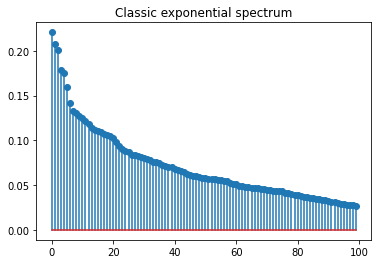

In [285]:
plt.stem(full_pca.explained_variance_)
plt.title('Classic exponential spectrum');

In [ ]:
import h5py

data = h5py.File(f'neural_BLAD.h5', 'r')
train_input = Tensor(data['train_data'][:]) #(num_trials, len_trial, num_neurons)
valid_input = Tensor(data['valid_data'][:])
train_output = Tensor(data['train_full_behavior'][:]) #(num_trials, len_trial, num_neurons)
valid_output = Tensor(data['valid_full_behavior'][:])

input_size = train_input.shape[-1]
output_size = train_output.shape[-1]

# print(data.keys())

In [291]:
# LFADS Hyper parameters
data_dim = train_data.shape[2]  # input to lfads should have dimensions:
ntimesteps = train_data.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 100      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 64         # encoder dim
con_dim = 0          # controller dim
ii_dim = 0           # inferred input dim
gen_dim = 64         # generator dim, should be large enough to generate integrator RNN dynamics
factors_dim = 8      # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002

# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

num_batches = 20000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.01            # initial learning rate
decay_factor = 0.9998       # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.95             # dropout keep rate during training

# Numerical stability HPs
max_grad_norm = 10.0        # gradient clipping above this value

# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 0.0 # batch number to start KL warm-up, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with KL warm-up, explicitly float
kl_min = 0.001 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-4}

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

lfads_hps = hashabledict(lfads_hps)
lfads_opt_hps = hashabledict(lfads_opt_hps)

assert num_batches >= print_every and num_batches % print_every == 0

In [292]:
from lfads_tutorial.lfads import sigmoid

def vanilla_rnn_params(key, n, u, ifactor=1.0, hfactor=1.0, hscale=0.0):
  """Generate Vanilla RNN parameters

  Arguments:
    key: random.PRNGKey for random bits
    n: hidden state size
    u: input size
    ifactor: scaling factor for input weights
    hfactor: scaling factor for hidden -> hidden weights
    hscale: scale on h0 initial condition

  Returns:
    a dictionary of parameters
  """
  key, skeys = utils.keygen(key, 5)
  ifactor = ifactor / np.sqrt(u)
  hfactor = hfactor / np.sqrt(n)

  wRUH = random.normal(next(skeys), (n+n,n)) * hfactor
  wRUX = random.normal(next(skeys), (n+n,u)) * ifactor
  wRUHX = np.concatenate([wRUH, wRUX], axis=1)

  return {'h0' : random.normal(next(skeys), (n,)) * hscale,
          'wRUHX' : wRUHX,
          'bRU' : np.zeros((n+n,))}


def vanilla_rnn(params, h, x):
  """Implement the Vanilla RNN equations.

  Arguments:
    params: dictionary of RNN parameters
    h: np array of hidden state
    x: np array of input

  Returns:
    np array of hidden state after RNN update"""
  bfg = 0.5
  hx = np.concatenate([h, x], axis=0)
  ru = np.dot(params['wRUHX'], hx) + params['bRU']
  r, u = np.split(ru, 2, axis=0)
  u = u + bfg
  r = sigmoid(r)
  u = sigmoid(u)
  rhx = np.concatenate([r * h, x])
  c = np.tanh(np.dot(params['wCHX'], rhx) + params['bC'])
  return u * h + (1.0 - u) * c



In [293]:
# Initialize parameters for LFADS
key = random.PRNGKey(onp.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps)
#, \
 #                                gen_rnn_params=gru_params)

In [294]:
key = random.PRNGKey(onp.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,\
                   train_data, eval_data) #, gen=gru)

Batches 1-100 in 16.35 sec, Step size: 0.00980
    Training losses 1430 = NLL 1430 + KL IC 6,0 + KL II 0,0 + L2 0.04
        Eval losses 1445 = NLL 1445 + KL IC 6,0 + KL II 0,0 + L2 0.04
Batches 101-200 in 2.44 sec, Step size: 0.00961
    Training losses 1531 = NLL 1530 + KL IC 6,1 + KL II 0,0 + L2 0.07
        Eval losses 1472 = NLL 1472 + KL IC 5,0 + KL II 0,0 + L2 0.07
Batches 201-300 in 2.43 sec, Step size: 0.00942
    Training losses 1494 = NLL 1493 + KL IC 4,1 + KL II 0,0 + L2 0.10
        Eval losses 1482 = NLL 1481 + KL IC 4,1 + KL II 0,0 + L2 0.10
Batches 301-400 in 2.43 sec, Step size: 0.00923
    Training losses 1549 = NLL 1547 + KL IC 4,1 + KL II 0,0 + L2 0.12
        Eval losses 1491 = NLL 1490 + KL IC 3,1 + KL II 0,0 + L2 0.12
Batches 401-500 in 2.49 sec, Step size: 0.00905
    Training losses 1495 = NLL 1493 + KL IC 3,1 + KL II 0,0 + L2 0.13
        Eval losses 1453 = NLL 1452 + KL IC 3,1 + KL II 0,0 + L2 0.13
Batches 501-600 in 2.49 sec, Step size: 0.00887
    Training 

In [299]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = ('trained_params_lfads_129_gru' + fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

print("Saving parameters: ", network_path)
onp.savez(network_path, trained_params)


Saving parameters:  /content/lfads/output/trained_params_lfads_129_gru2022-07-29_20:58:19.npz


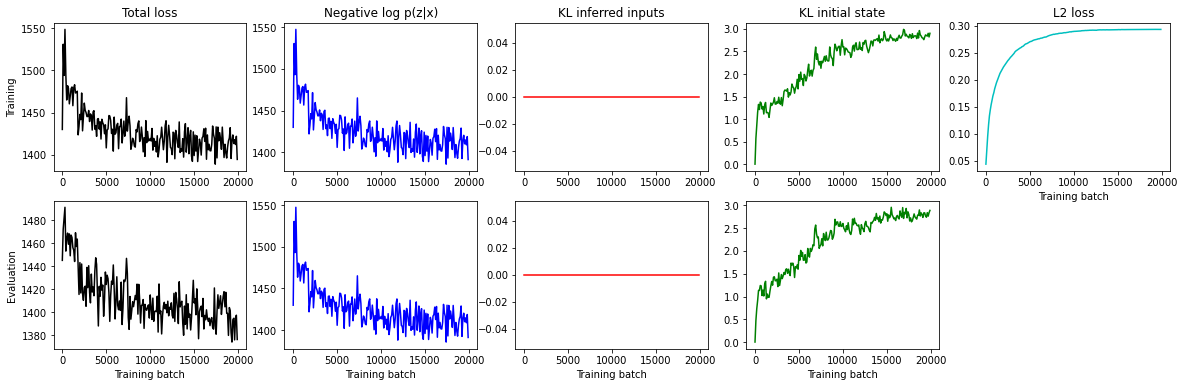

In [300]:
# Plot the training details
x = onp.arange(0, num_batches, print_every)
plt.figure(figsize=(20,6))
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');

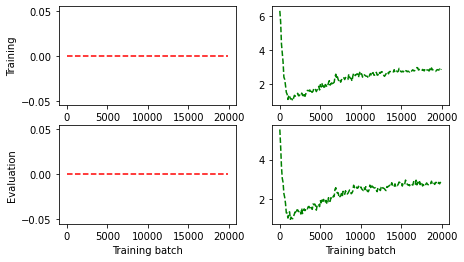

In [301]:
# See the effect of the KL warmup, which is shown 
# by the KL penalities without the warmup scaling. 
plt.figure(figsize=(7,4))
plt.subplot(221)
plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Training')
plt.subplot(222)
plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
plt.subplot(223)
plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Evaluation')
plt.xlabel('Training batch')
plt.subplot(224)
plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
plt.xlabel('Training batch');

## Visualization

In [302]:
# Plot a bunch of examples of eval trials run through LFADS.
reload(plotting)
#reload(lfads)

def plot_rescale_fun(a): 
    fac = max_firing_rate * data_dt
    return renormed_fun(a) * fac


bidx = 0

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[bidx,:,:].astype(np.float32)
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example)

    # The inferred input and true input are rescaled and shifted via 
    # linear regression to match, as there is an identifiability issue. there.
    plotting.plot_lfads(psa_example, psa_dict,
                        data_dict, eval_data_offset+bidx, plot_rescale_fun)


NameError: ignored

dict_keys(['c_t', 'factor_t', 'gen_t', 'ic_logvar', 'ic_mean', 'ii_logvar_t', 'ii_mean_t', 'ii_t', 'lograte_t', 'xenc_t'])

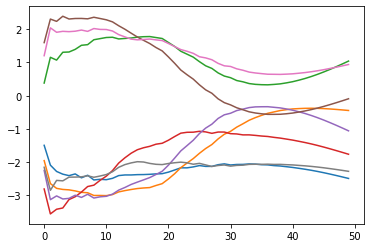

In [374]:
# plt.plot(psa_dict['factor_t'])
plt.plot(psa_dict['factor_t'])
psa_dict.keys()

In [376]:
ics = onp.empty((data_bxtxn.shape[0],gen_dim))
gen_traj = onp.empty((data_bxtxn.shape[0],ntimesteps,gen_dim))
for i, psa_example in enumerate(data_bxtxn.astype(np.float32)):
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example)
    ics[i] = psa_dict['ic_mean']
    gen_traj[i] = psa_dict['gen_t']

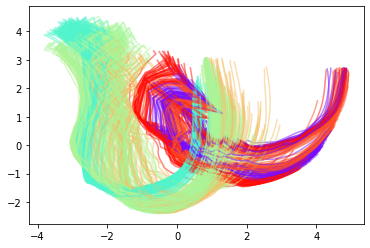

In [397]:

ncomponents = 3
pca = sklearn.decomposition.PCA(ncomponents)
pca.fit(onp.reshape(gen_traj, [-1, gen_dim]))

S = pca.components_.T

for a,t in zip(reach_angle,gen_traj):
  plt.plot(*(t@S)[:,[1,2]].T, c=plt.cm.rainbow(a / (2*onp.pi) + 0.5),alpha=0.5)

In [434]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# for a,t in zip(reach_angle,gen_traj):
#   plt.plot(*(t@S).T, c=plt.cm.rainbow(a / (2*onp.pi) + 0.5),alpha=0.5)
# ax.view_init(-120, 120)

import plotly.express as px
import pandas as pd

# print((gen_traj@S)[:,0])

df = pd.DataFrame.from_dict({'PC0': (gen_traj@S)[...,0].flatten(),
                             'PC1': (gen_traj@S)[...,1].flatten(),
                             'PC2': (gen_traj@S)[...,2].flatten(),
                             'color': reach_angle.repeat(ntimesteps).flatten()})

fig = px.scatter_3d(df, x="PC0", y="PC1", z="PC2",color='color')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=.01,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


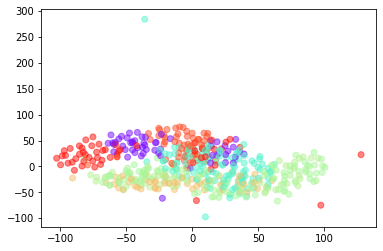

In [373]:
# from sklearn.manifold import TSNE

ncomponents = 3
tsne = TSNE(ncomponents,perplexity=40)
embedded_ics = tsne.fit_transform(ics)

conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()

# Loop over conditions and compute average trajectory
reach_angle = onp.empty(len(dataset.trial_info)).astype('float32')
for cond in conds:
    # Find trials in condition
    mask = onp.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Determine reach angle for color
    active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
    reach_angle[mask] = onp.arctan2(*active_target[::-1])

plt.scatter(*embedded_ics[:,:2].T, c=plt.cm.rainbow(reach_angle[:] / (2*onp.pi) + 0.5),alpha=0.5)

(array([ 56.,   0.,   0.,   0., 111., 112.,  56.,  56.,   0., 109.]),
 array([0.01586276, 0.11239066, 0.20891856, 0.30544646, 0.40197435,
        0.49850225, 0.59503015, 0.69155805, 0.78808595, 0.88461385,
        0.98114175]),
 <a list of 10 Patch objects>)

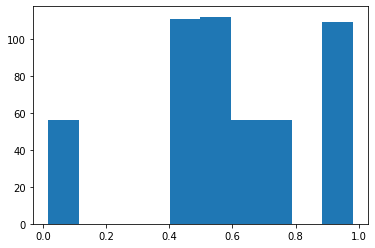

In [363]:
plt.hist(reach_angle[:] / (2*onp.pi) + 0.5)

In [ ]:
print(trained_params.keys())
trained_params['gen'].keys()

dict_keys(['con', 'con_out', 'factors', 'gen', 'gen_ic', 'ic_enc', 'ic_prior', 'ii_prior', 'logrates'])


dict_keys(['bC', 'bRU', 'h0', 'wCHX', 'wRUHX'])

In [ ]:
np.max(angles[eval_data_offset:]+1.5*onp.pi)

DeviceArray(2.9996955, dtype=float32)